In [1]:
import torch
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from einops import repeat
from pathlib import Path

import pytorch_lightning
from torchmetrics import ConfusionMatrix

from bliss.catalog import convert_flux_to_magnitude

In [2]:
cmap = plt.get_cmap("Dark2")
def get_color(i):
    assert i < 8
    return cmap(i)

In [3]:
cached_data_path = Path("/data/scratch/pduan/posterior_cached_files")

In [4]:
seed = 7272
pytorch_lightning.seed_everything(seed=seed)

Seed set to 7272


7272

In [5]:
cached_file_name_dict = {
    "bliss": "bliss_posterior_exp_03-30-1_encoder_44.ckpt_b_800_iter_500_seed_7272.pt",
    "ynet": "ynet_v2_diffusion_posterior_exp_04-04-2_encoder_168.ckpt_b_720_iter_500_seed_7272.pt",
    "mdt": "nfs_files/mdt_posterior_great_lake_exp_04-14-1_encoder_152.ckpt_b_800_iter_500_seed_7272.pt",
    # "simple_net (pred noise)": "simple_net_v2_diffusion_posterior_exp_04-07-1_encoder_97.ckpt_b_720_iter_500_seed_7272.pt",
    # "mdt": "nfs_files/mdt_posterior_exp_04-12-1_encoder_46.ckpt_b_800_iter_400_seed_7272.pt",
    # "simple_net": "nfs_files/simple_net_posterior_great_lake_exp_04-14-2_encoder_41.ckpt_b_800_iter_500_seed_7272.pt",
    # "simple_net_speed": "nfs_files/simple_net_speed_posterior_great_lake_exp_04-14-3_encoder_84.ckpt_b_800_iter_500_seed_7272.pt",
    # "simple_ar_net": "nfs_files/simple_ar_net_posterior_great_lake_exp_04-14-4_encoder_95.ckpt_b_800_iter_500_seed_7272.pt",
    # "simple_cond_true_net": "nfs_files/simple_cond_true_net_posterior_great_lake_exp_04-14-5_encoder_78.ckpt_b_800_iter_500_seed_7272.pt",
}

In [6]:
cached_data_dict = {}
for k, v in cached_file_name_dict.items():
    with open(cached_data_path / v, "rb") as f:
        cached_data_dict[k] = torch.load(f, map_location="cpu")

### Locs CI

In [7]:
def get_locs_ci(on_mask_locs, on_mask_target_locs, both_on_mask,
                ci_cover: list[float], for_vertical_locs: bool):
    left_q_points = [(1.0 - c) / 2 for c in ci_cover]
    right_q_points = [1.0 - lq for lq in left_q_points]
    actual_ci_cover = []
    if for_vertical_locs:
        locs_index = 0
    else:
        locs_index = 1

    for q in zip(left_q_points, right_q_points):
        q = torch.tensor(q)
        on_mask_locs_q = on_mask_locs.nanquantile(q=q, dim=-2).permute([1, 2, 0])  # (matched_sources, 2, 2)
        above_lower_bound = on_mask_target_locs[:, locs_index] > on_mask_locs_q[:, locs_index, 0]
        below_upper_bound = on_mask_target_locs[:, locs_index] < on_mask_locs_q[:, locs_index, 1]
        actual_ci_cover.append((above_lower_bound & below_upper_bound).sum() / both_on_mask.sum())
    return actual_ci_cover

In [8]:
def plot_data_for_locs_ci(result_dict, ci_cover):
    init_n_sources = result_dict["init_n_sources"]
    n_sources_list = result_dict["n_sources_list"]
    locs_list = result_dict["locs_list"]
    target_n_sources = result_dict["target_n_sources"]
    target_locs = result_dict["target_locs"]

    both_on_mask = (target_n_sources > 0) & (init_n_sources > 0)  # (b, h, w)
    pred_n_sources_mask = (torch.stack(n_sources_list, dim=-1) > 0).unsqueeze(-1)  # (b, h, w, iter, 1)
    all_locs = torch.cat(locs_list, dim=-2)  # (b, h, w, iter, 2)
    all_locs = torch.where(pred_n_sources_mask, all_locs, torch.nan)
    both_on_mask_iter_repeated = repeat(both_on_mask, 
                                        "b h w -> b h w iter k",
                                        iter=all_locs.shape[-2],
                                        k=all_locs.shape[-1])  # (b, h, w, iter, 2)
    both_on_mask_single_repeated = repeat(both_on_mask, 
                                        "b h w -> b h w 1 k",
                                        k=all_locs.shape[-1])  # (b, h, w, 1, 2)
    on_mask_locs = all_locs[both_on_mask_iter_repeated].view(-1, all_locs.shape[-2], 2)  # (matched_sources, iter, 2)
    on_mask_target_locs = target_locs[both_on_mask_single_repeated].view(-1, 2)  # (matched_sources, 2)
    v_ci_cover = get_locs_ci(on_mask_locs, on_mask_target_locs, both_on_mask,
                             ci_cover=ci_cover,
                             for_vertical_locs=True)
    h_ci_cover = get_locs_ci(on_mask_locs, on_mask_target_locs, both_on_mask,
                             ci_cover=ci_cover,
                             for_vertical_locs=False)
    return v_ci_cover, h_ci_cover

In [9]:
def draw_locs_ci_plot():
    ci_cover = [i / 100 for i in range(5, 100, 5)]
    locs_ci_dict = {}
    for k, v in cached_data_dict.items():
        locs_ci_dict[k] = plot_data_for_locs_ci(v, ci_cover)
    plt.figure(figsize=(10, 10))
    for i, (k, v) in enumerate(locs_ci_dict.items()):
        plt.plot(ci_cover, v[0], label=k.upper(), color=get_color(i))
    plt.plot(ci_cover, ci_cover, linestyle="dashed", label="Expected Coverage")
    plt.xlabel("Expected Vertical Locs CI Coverage")
    plt.ylabel("Actual Vertical Locs CI Coverage")
    plt.legend()
    plt.xticks(ci_cover)
    plt.yticks(ci_cover)
    plt.grid()
    plt.show()

    plt.figure(figsize=(10, 10))
    for i, (k, v) in enumerate(locs_ci_dict.items()):
        plt.plot(ci_cover, v[1], label=k.upper(), color=get_color(i))
    plt.plot(ci_cover, ci_cover, linestyle="dashed", label="Expected Coverage")
    plt.xlabel("Expected Horizontal Locs CI Coverage")
    plt.ylabel("Actual Horizontal Locs CI Coverage")
    plt.legend()
    plt.xticks(ci_cover)
    plt.yticks(ci_cover)
    plt.grid()
    plt.show()

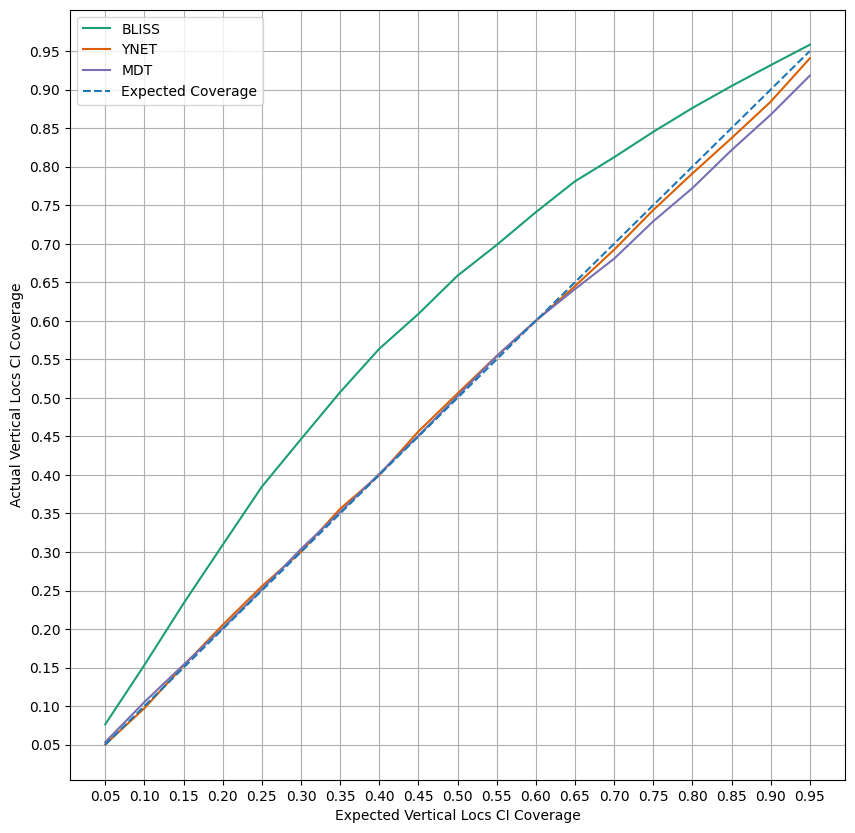

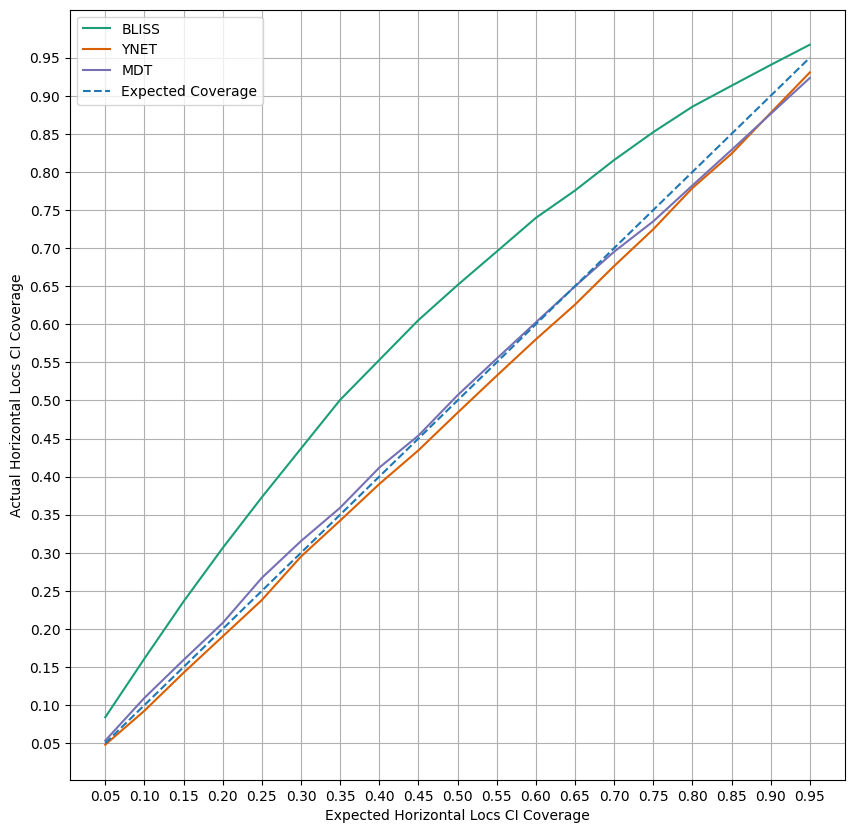

In [10]:
draw_locs_ci_plot()

### Fluxes CI

In [11]:
def plot_data_for_fluxes_ci(result_dict, ci_cover, flux_mag_min, flux_mag_max):
    init_n_sources = result_dict["init_n_sources"]
    n_sources_list = result_dict["n_sources_list"]
    fluxes_list = result_dict["fluxes_list"]
    target_n_sources = result_dict["target_n_sources"]
    target_fluxes = result_dict["target_fluxes"]

    both_on_mask = (target_n_sources > 0) & (init_n_sources > 0)  # (b, h, w)
    pred_n_sources_mask = (torch.stack(n_sources_list, dim=-1) > 0).unsqueeze(-1)  # (b, h, w, iter, 1)
    all_fluxes = torch.cat(fluxes_list, dim=-2)  # (b, h, w, iter, 6)
    all_fluxes = torch.where(pred_n_sources_mask, all_fluxes, torch.nan)
    # zero_point_mask = (all_fluxes > 147) & (all_fluxes < 148)
    # all_fluxes = torch.where(zero_point_mask, torch.nan, all_fluxes)
    both_on_mask_iter_repeated = repeat(both_on_mask, 
                                        "b h w -> b h w iter k",
                                        iter=all_fluxes.shape[-2],
                                        k=all_fluxes.shape[-1])  # (b, h, w, iter, 6)
    both_on_mask_single_repeated = repeat(both_on_mask, 
                                        "b h w -> b h w 1 k",
                                        k=all_fluxes.shape[-1])  # (b, h, w, 1, 6)
    on_mask_fluxes = all_fluxes[both_on_mask_iter_repeated].view(-1, all_fluxes.shape[-2], 6)  # (matched_sources, iter, 6)
    on_mask_target_fluxes = target_fluxes[both_on_mask_single_repeated].view(-1, 6)  # (matched_sources, 6)

    left_q_points = [(1.0 - c) / 2 for c in ci_cover]
    right_q_points = [1.0 - lq for lq in left_q_points]
    actual_ci_cover = {band: [] for band in "ugrizy"}
    for q in zip(left_q_points, right_q_points):
        q = torch.tensor(q)
        on_mask_est_flux_q = on_mask_fluxes.nanquantile(q=q, dim=-2).permute([1, 2, 0])  # (matched_sources, 6, 2)
        for i, band in zip(range(6), "ugrizy"):
            above_lower_bound = on_mask_target_fluxes[:, i] > on_mask_est_flux_q[:, i, 0]
            below_upper_bound = on_mask_target_fluxes[:, i] < on_mask_est_flux_q[:, i, 1]  # (matched_sources, )
            on_mask_target_mag = convert_flux_to_magnitude(on_mask_target_fluxes[:, i], zero_point=3631e9)
            valid_on_mask_target_mag = (on_mask_target_mag > flux_mag_min) & (on_mask_target_mag <= flux_mag_max)  # (matched_sources, )
            actual_ci_cover[band].append(((above_lower_bound & below_upper_bound)[valid_on_mask_target_mag].sum() / valid_on_mask_target_mag.sum()).item())
    
    for k, v in actual_ci_cover.items():
        actual_ci_cover[k] = torch.tensor(v)

    return actual_ci_cover

In [12]:
def draw_fluxes_ci_plot(flux_mag_min, flux_mag_max):
    ci_cover = torch.tensor([i / 100 for i in range(5, 100, 5)])
    fluxes_ci_dict = {}
    for k, v in cached_data_dict.items():
        fluxes_ci_dict[k] = plot_data_for_fluxes_ci(v, 
                                                    ci_cover=ci_cover,
                                                    flux_mag_min=flux_mag_min, 
                                                    flux_mag_max=flux_mag_max)
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    for i, (ax, band) in enumerate(zip(axes.flatten(), "ugrizy")):
        for ki, (k, v) in enumerate(fluxes_ci_dict.items()):
            ax.plot(ci_cover, v[band], label=k.upper(), color=get_color(ki))
        ax.plot(ci_cover, ci_cover, linestyle="dashed", label="Expected Coverage")
        ax.set_xlabel("Expected CI Coverage")
        ax.set_ylabel("Actual CI Coverage")
        if i == 0:
            ax.legend()
        ax.set_title(f"Band {band}")
        ax.set_xticks(ci_cover)
        ax.tick_params(axis="x", labelrotation=45)
        ax.set_yticks(ci_cover)
        ax.grid()
    fig.suptitle(f"Magnitude [{flux_mag_min:.1f}, {flux_mag_max:.1f}]")
    fig.tight_layout()
    fig.show()

    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    for i, (ax, band) in enumerate(zip(axes.flatten(), "ugrizy")):
        for ki, (k, v) in enumerate(fluxes_ci_dict.items()):
            ax.plot(ci_cover, v[band] - ci_cover, label=k.upper(), color=get_color(ki))
        ax.axhline(y=0, linestyle="dashed", label="Expected", color="green")
        ax.set_xlabel("Expected CI Coverage")
        ax.set_ylabel("Actual - Expected CI Coverage")
        if i == 0:
            ax.legend()
        ax.set_title(f"Band {band}")
        ax.set_xticks(ci_cover)
        ax.tick_params(axis="x", labelrotation=45)
        ax.grid()
    fig.suptitle(f"Magnitude [{flux_mag_min:.1f}, {flux_mag_max:.1f}]")
    fig.tight_layout()
    fig.show()

    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    for i, (ax, band) in enumerate(zip(axes.flatten(), "ugrizy")):
        for ki, (k, v) in enumerate(fluxes_ci_dict.items()):
            ax.plot(ci_cover, (v[band] - ci_cover).abs(), label=k.upper(), color=get_color(ki))
        ax.axhline(y=0, linestyle="dashed", label="Expected", color="green")
        ax.set_xlabel("Expected CI Coverage")
        ax.set_ylabel("|Actual - Expected| CI Coverage")
        if i == 0:
            ax.legend()
        ax.set_title(f"Band {band}")
        ax.set_xticks(ci_cover)
        ax.tick_params(axis="x", labelrotation=45)
        ax.grid()
    fig.suptitle(f"Magnitude [{flux_mag_min:.1f}, {flux_mag_max:.1f}]")
    fig.tight_layout()
    fig.show()

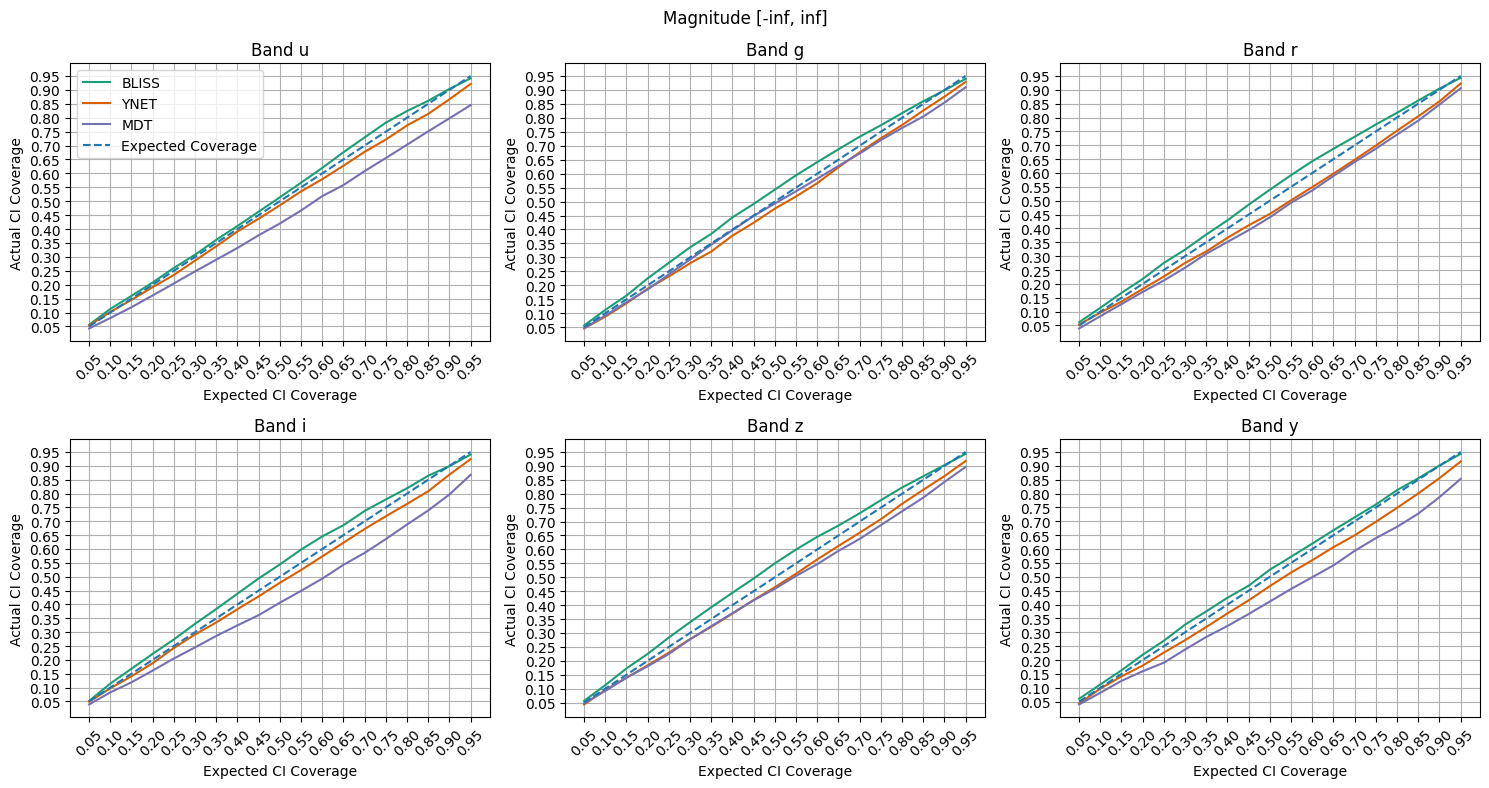

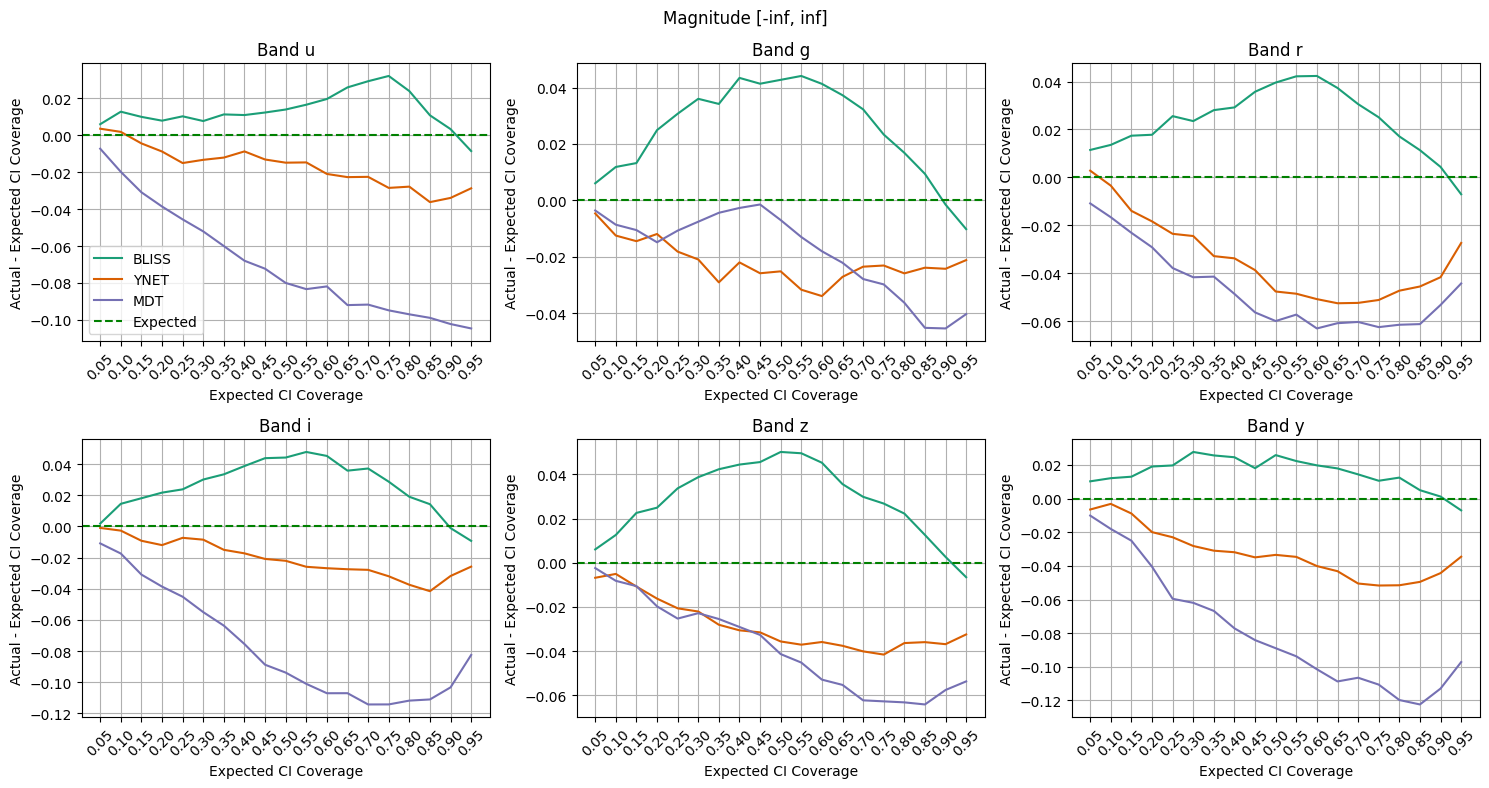

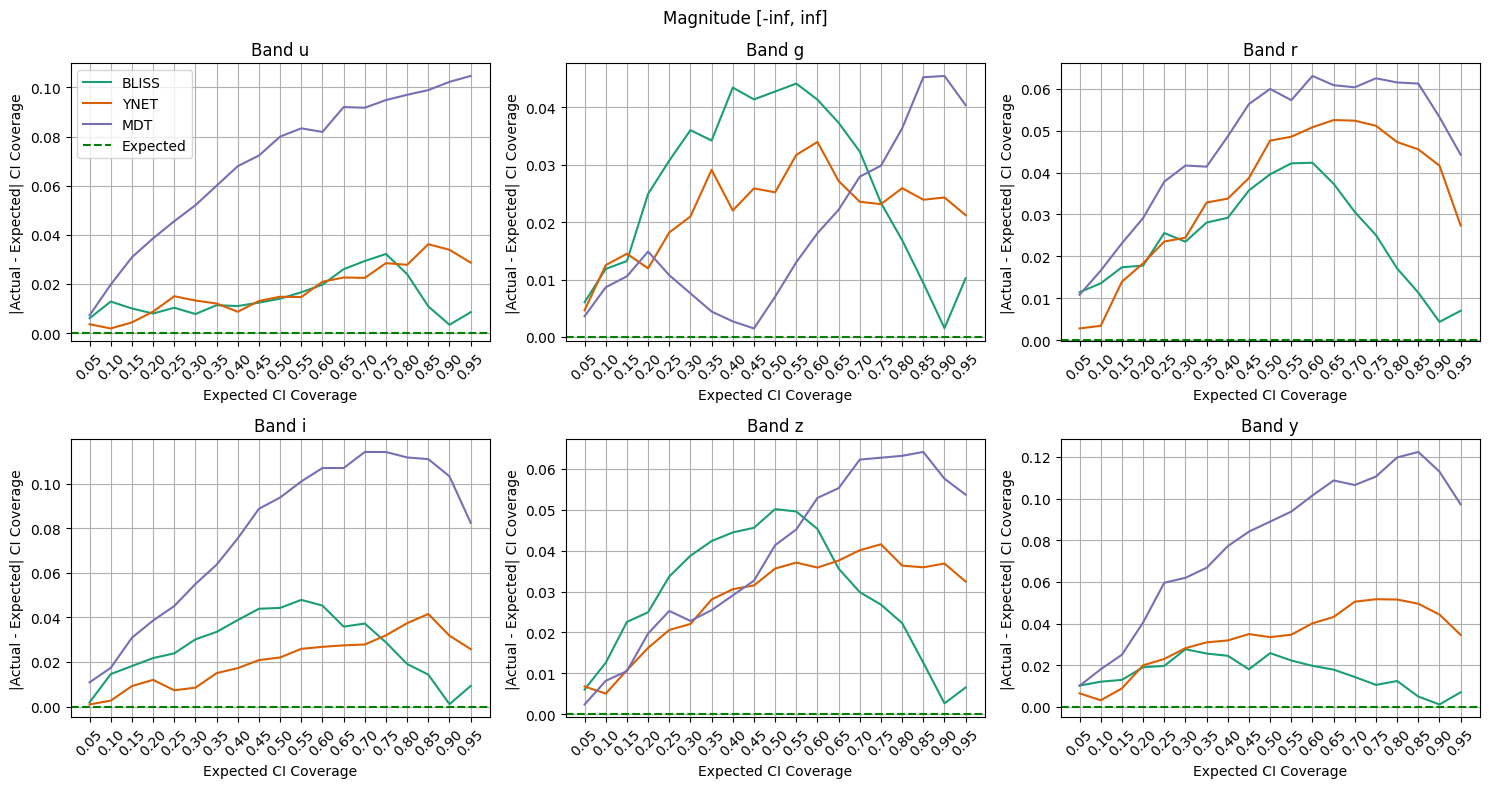

In [13]:
draw_fluxes_ci_plot(flux_mag_min=-torch.inf, flux_mag_max=torch.inf)

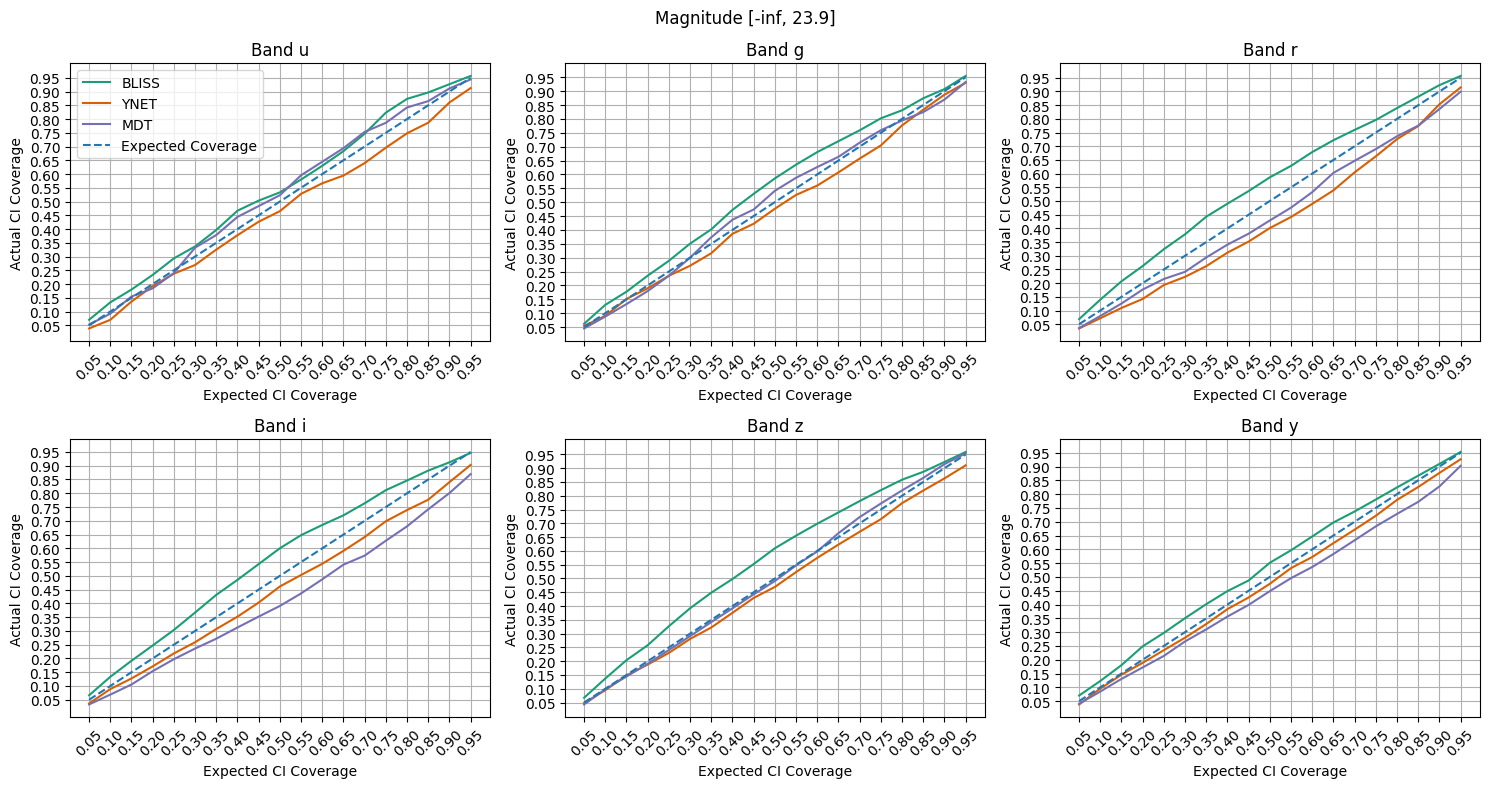

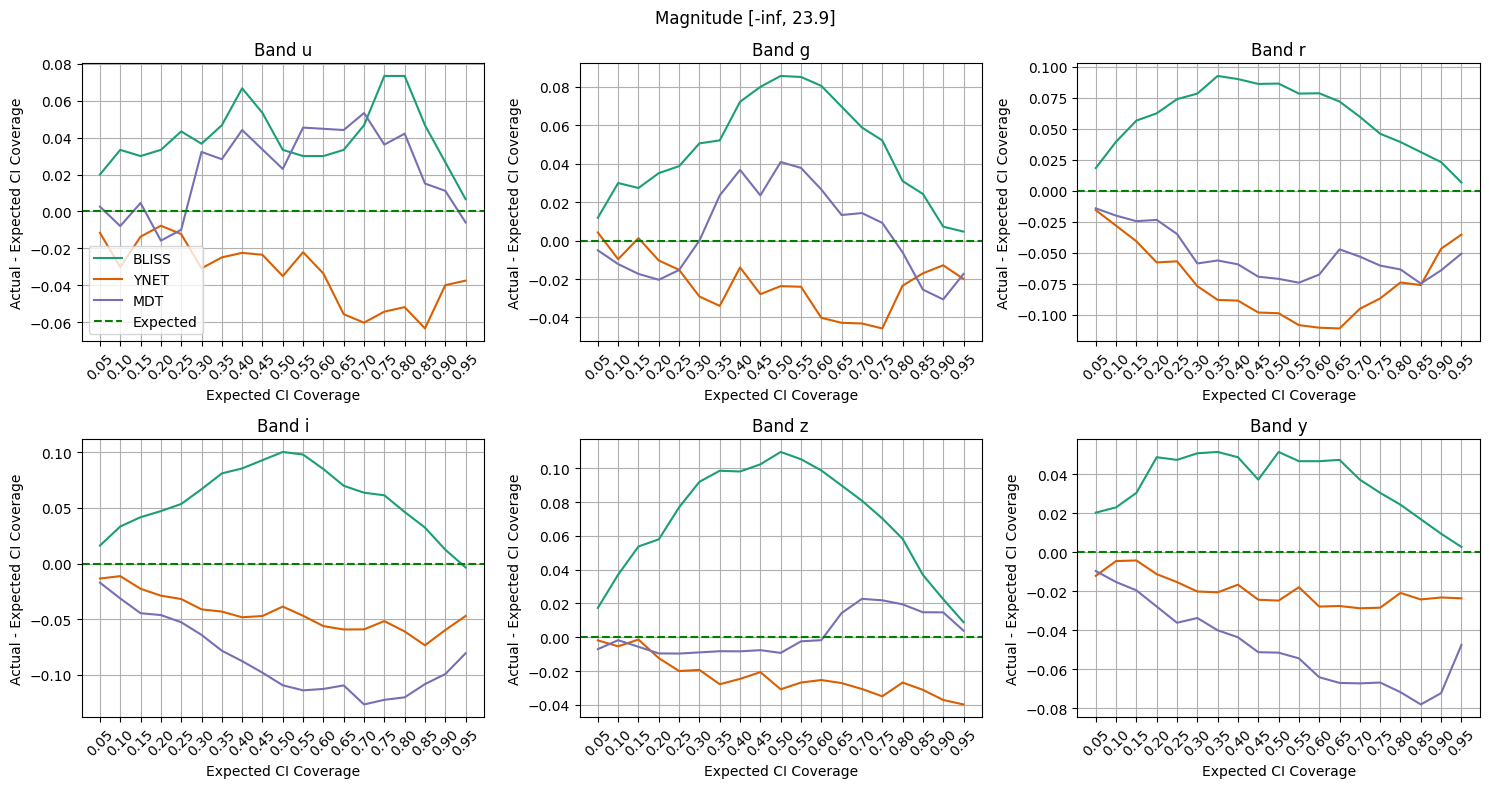

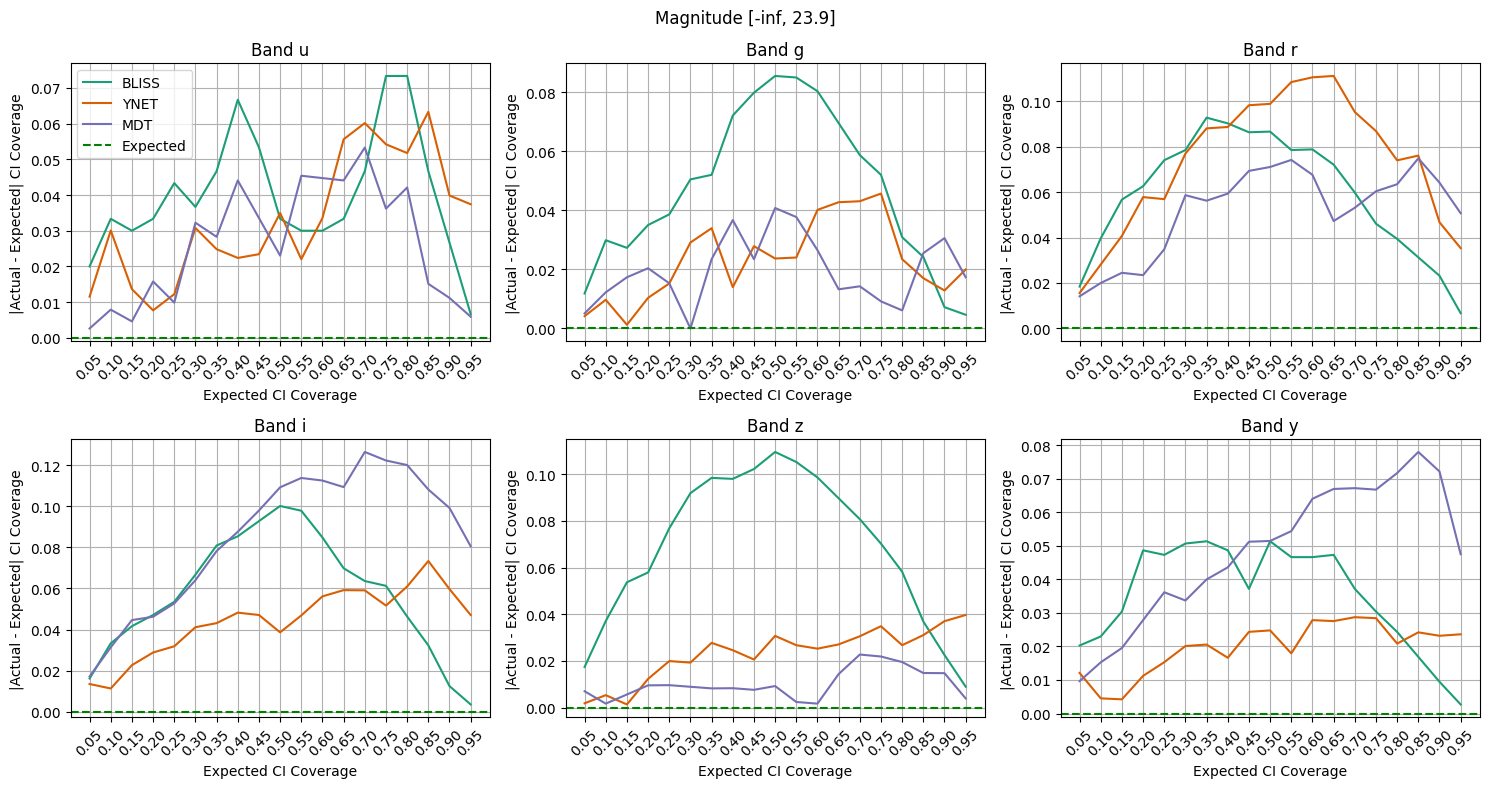

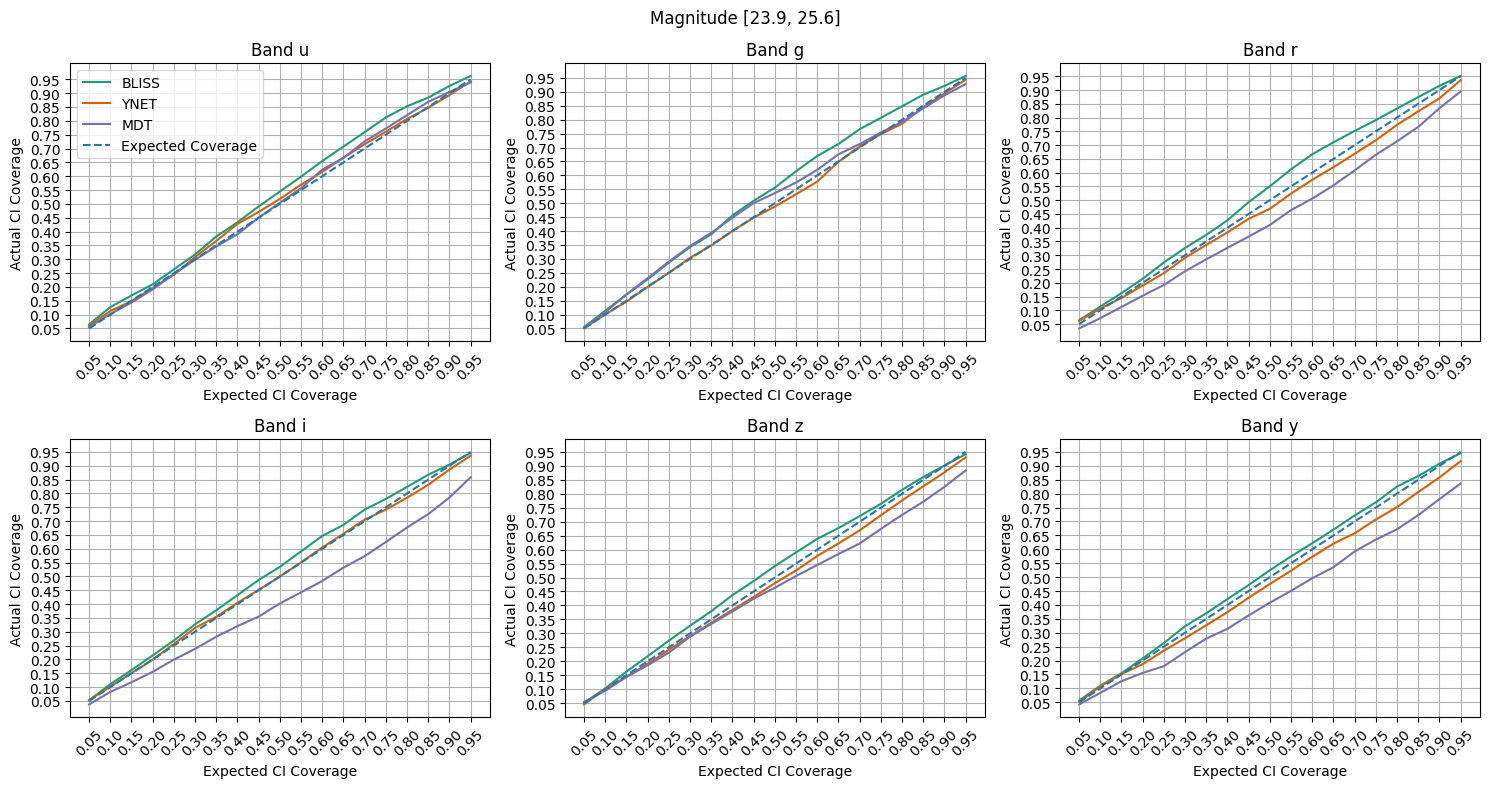

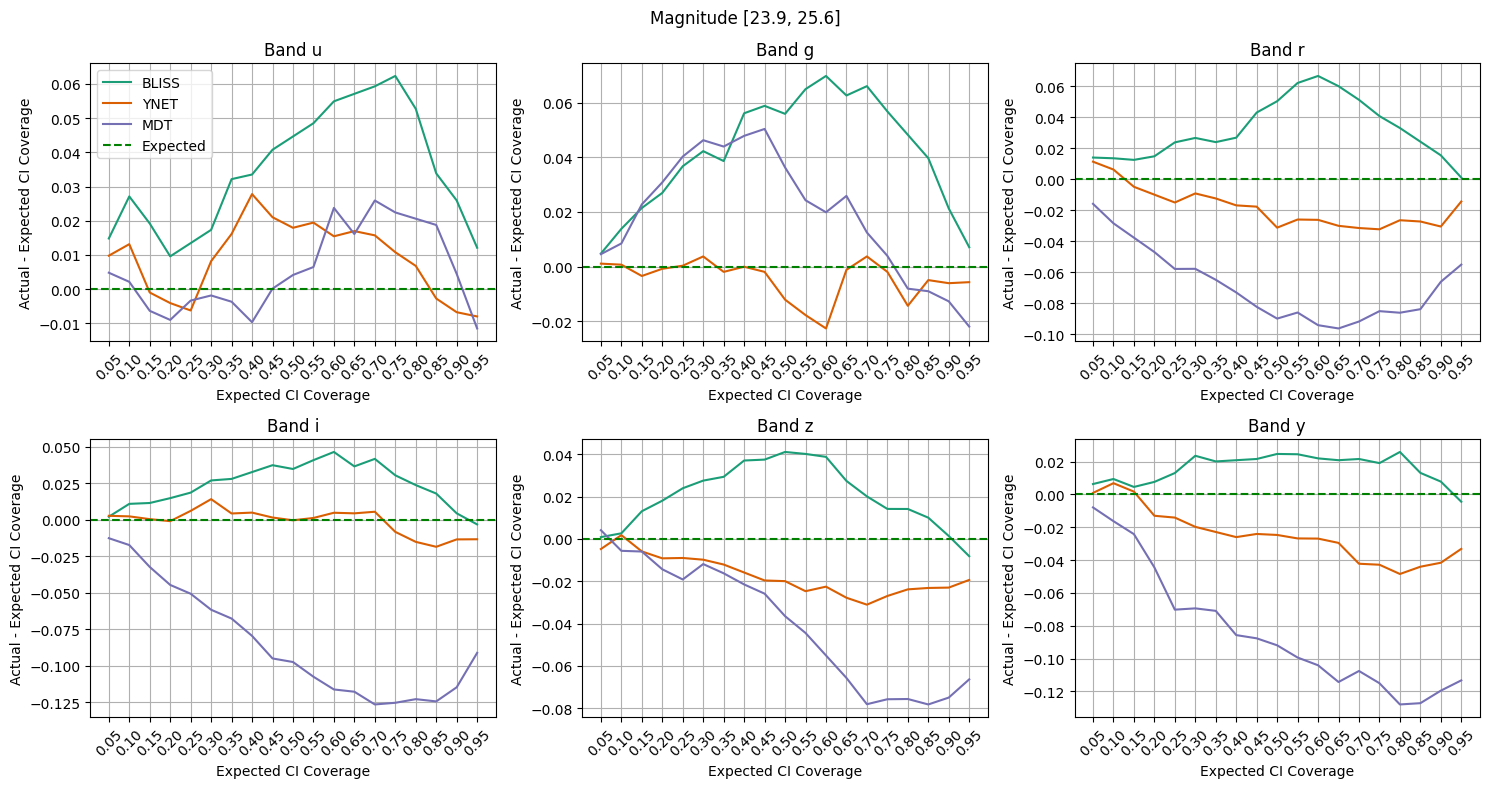

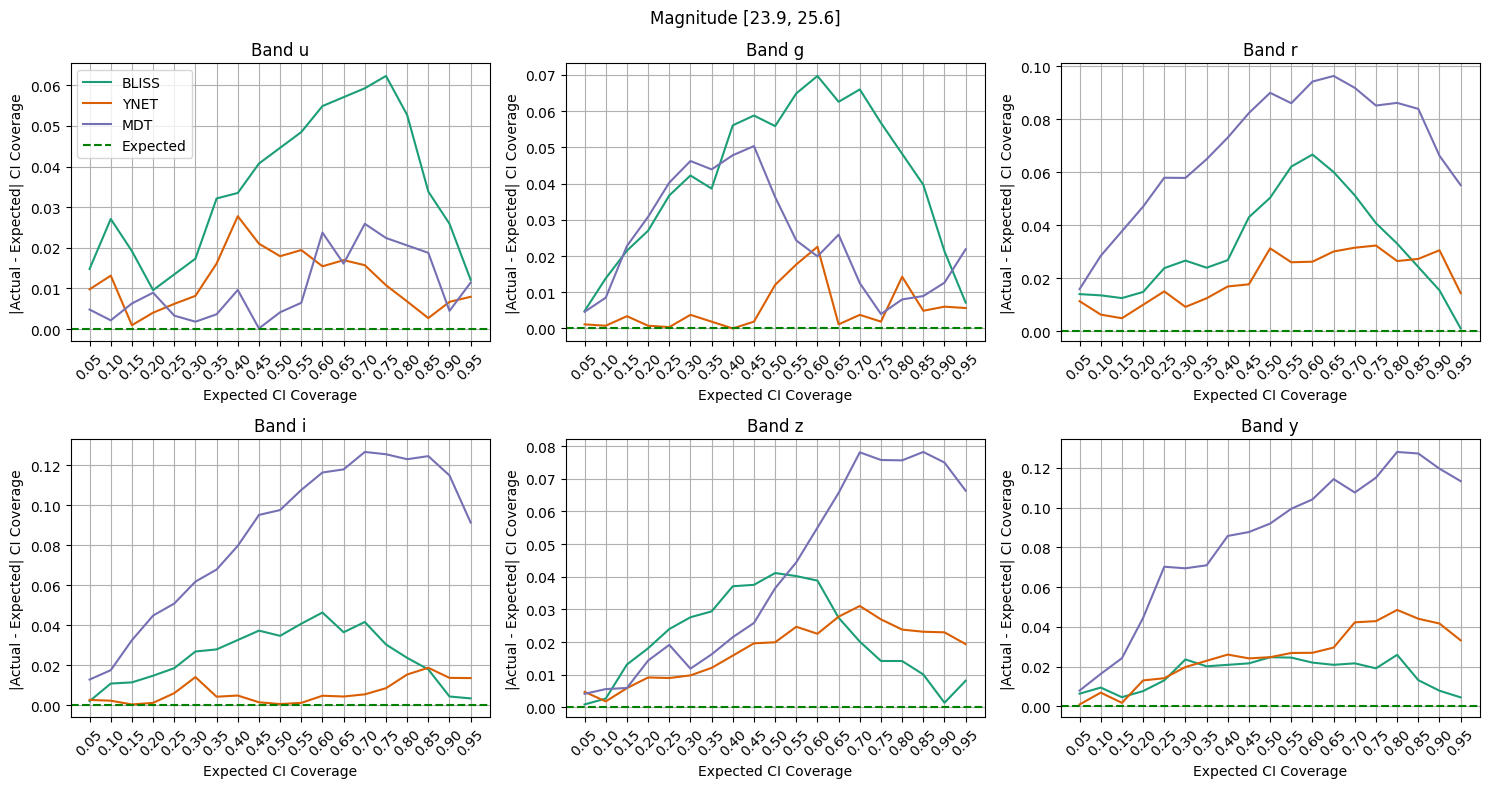

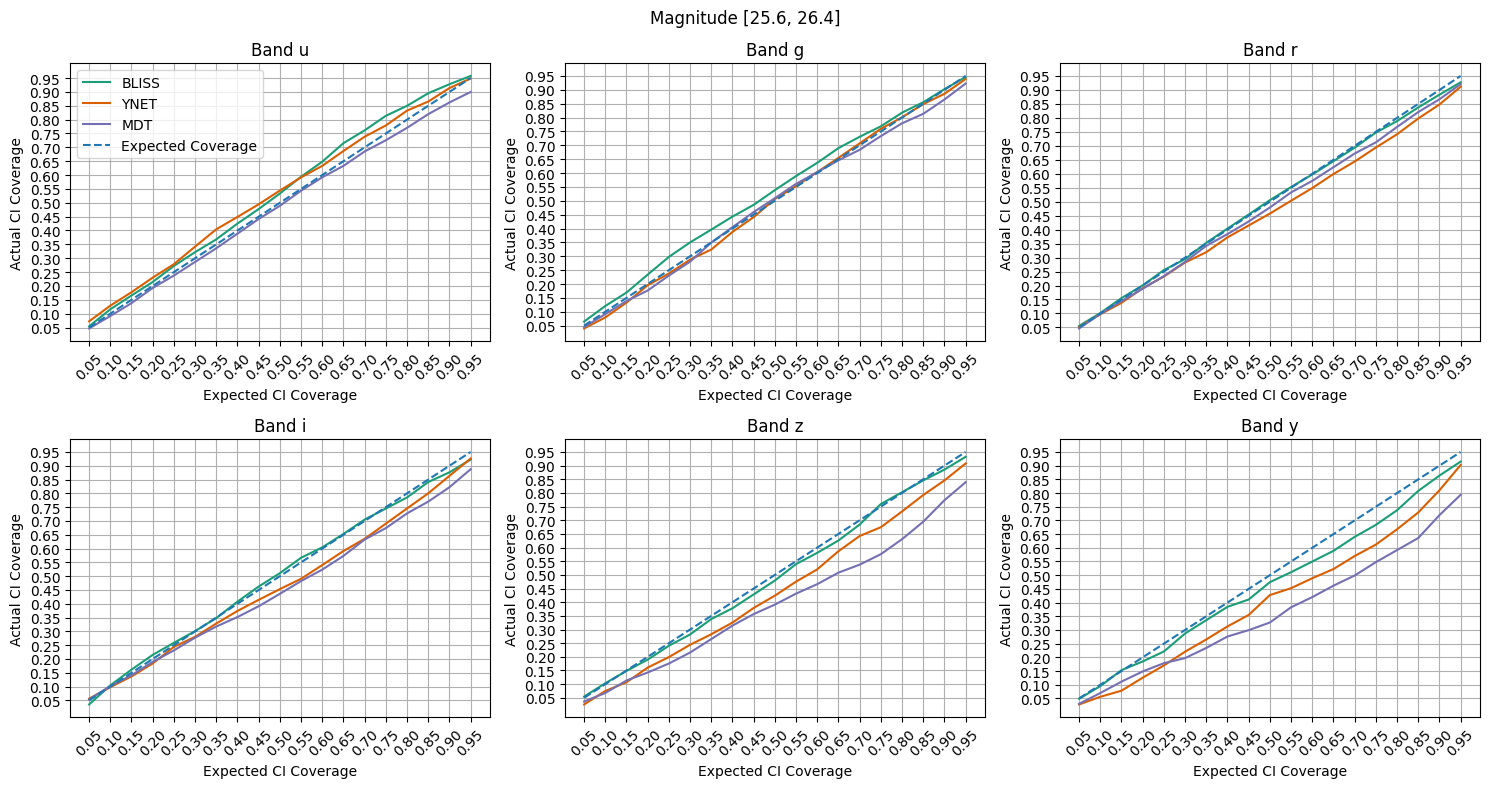

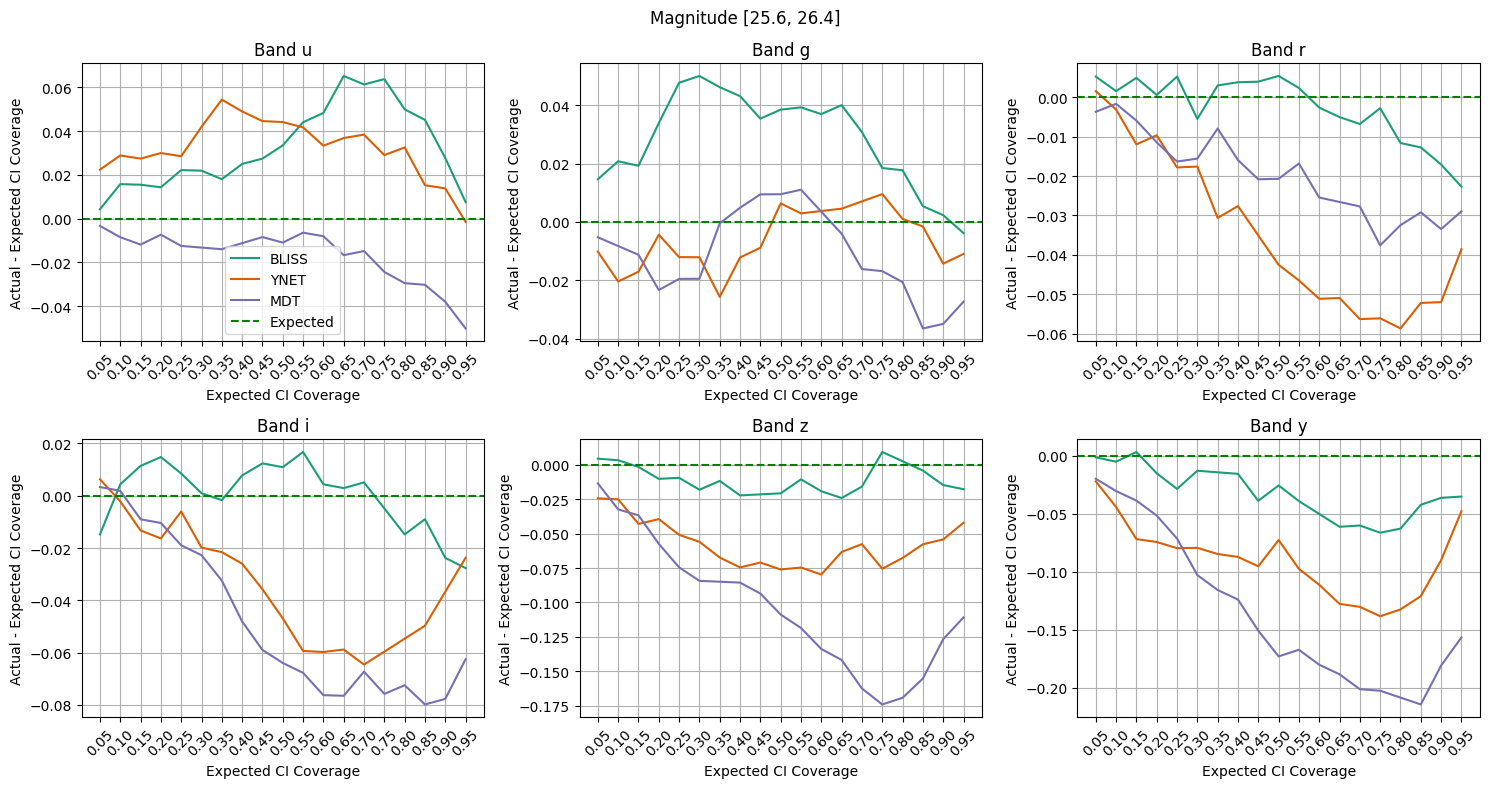

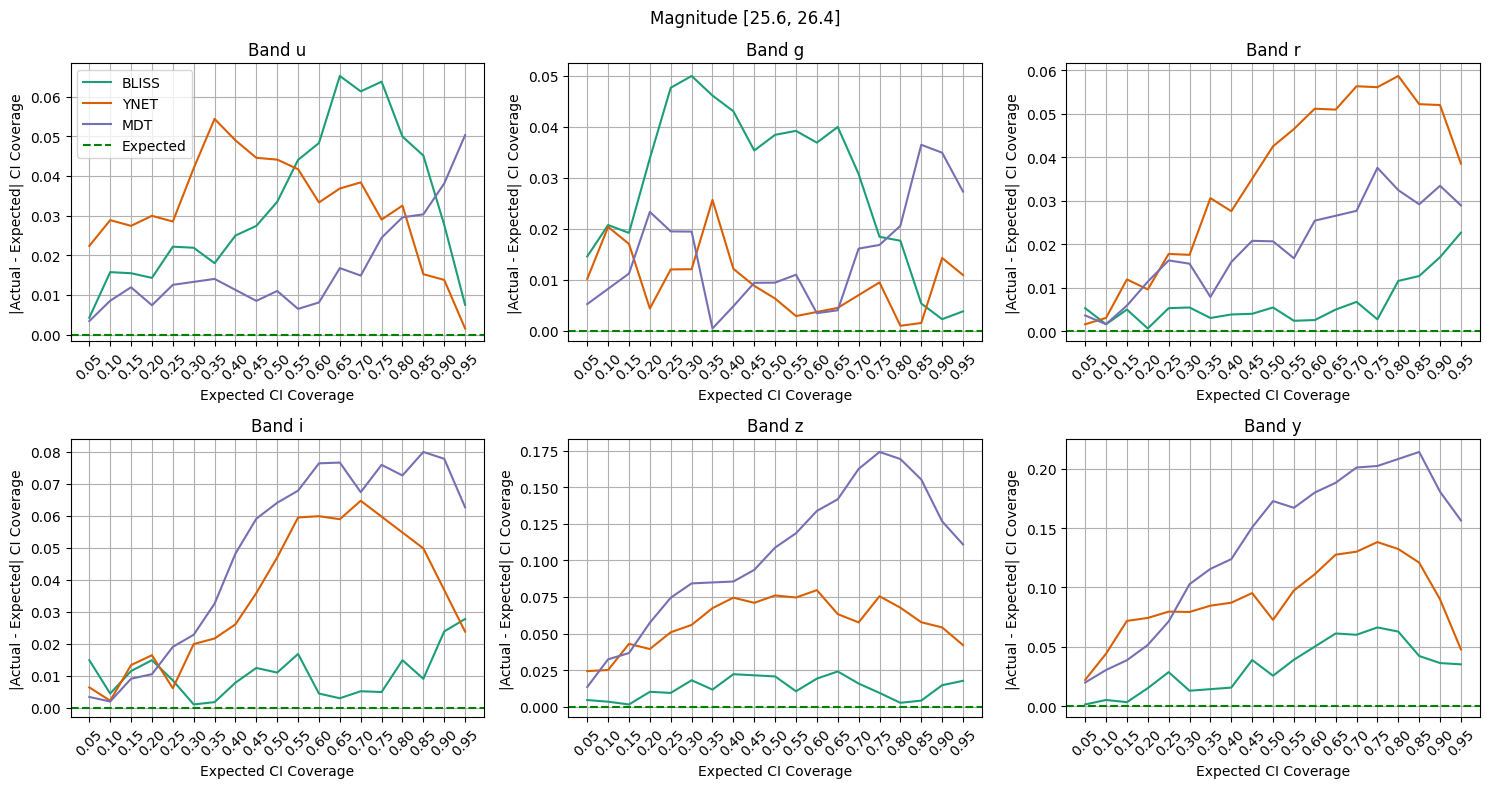

In [14]:
mag_boundaries = [-torch.inf, 23.9, 25.6, 26.4]
for mag_min, mag_max in zip(mag_boundaries[:-1], mag_boundaries[1:]):
    draw_fluxes_ci_plot(flux_mag_min=mag_min, flux_mag_max=mag_max)

### Fluxes CI Match

In [15]:
def plot_data_for_fluxes_ci_match(result_dict, ci_cover: float):
    init_n_sources = result_dict["init_n_sources"]
    n_sources_list = result_dict["n_sources_list"]
    fluxes_list = result_dict["fluxes_list"]
    target_n_sources = result_dict["target_n_sources"]
    target_fluxes = result_dict["target_fluxes"]

    both_on_mask = (target_n_sources > 0) & (init_n_sources > 0)  # (b, h, w)
    pred_n_sources_mask = (torch.stack(n_sources_list, dim=-1) > 0).unsqueeze(-1)  # (b, h, w, iter, 1)
    all_fluxes = torch.cat(fluxes_list, dim=-2)  # (b, h, w, iter, 6)
    all_fluxes = torch.where(pred_n_sources_mask, all_fluxes, torch.nan)
    # zero_point_mask = (all_fluxes > 147) & (all_fluxes < 148)
    # all_fluxes = torch.where(zero_point_mask, torch.nan, all_fluxes)
    both_on_mask_iter_repeated = repeat(both_on_mask, 
                                        "b h w -> b h w iter k",
                                        iter=all_fluxes.shape[-2],
                                        k=all_fluxes.shape[-1])  # (b, h, w, iter, 6)
    both_on_mask_single_repeated = repeat(both_on_mask, 
                                        "b h w -> b h w 1 k",
                                        k=all_fluxes.shape[-1])  # (b, h, w, 1, 6)
    on_mask_fluxes = all_fluxes[both_on_mask_iter_repeated].view(-1, all_fluxes.shape[-2], 6)  # (matched_sources, iter, 6)
    on_mask_target_fluxes = target_fluxes[both_on_mask_single_repeated].view(-1, 6)  # (matched_sources, 6)

    left_q_point = (1.0 - ci_cover) / 2
    right_q_point = 1.0 - left_q_point
    q = torch.tensor([left_q_point, right_q_point])
    on_mask_est_flux_q = on_mask_fluxes.nanquantile(q=q, dim=-2).permute([1, 2, 0])  # (matched_sources, 6, 2)
    on_mask_target_and_est_q = torch.cat([on_mask_target_fluxes.unsqueeze(-1), on_mask_est_flux_q], dim=-1)  # (matched_sources, 6, 3)
    return {
        band: convert_flux_to_magnitude(v.squeeze(1), zero_point=3631e9) 
        for band, v in zip("ugrizy", on_mask_target_and_est_q.chunk(6, dim=1))
    }

In [16]:
def draw_fluxes_ci_match_plot(ci_cover):
    fluxes_ci_match_dict = {}
    for k, v in cached_data_dict.items():
        fluxes_ci_match_dict[k] = plot_data_for_fluxes_ci_match(v, ci_cover=ci_cover)
    for method_i, (method_name, t_flux_and_est_q) in enumerate(fluxes_ci_match_dict.items()):
        fig, axes = plt.subplots(2, 3, figsize=(15, 8))
        for i, (ax, band) in enumerate(zip(axes.flatten(), "ugrizy")):
            cur_band_data = t_flux_and_est_q[band]
            target_flux = cur_band_data[:, 0]
            est_lb_err = (cur_band_data[:, 1] - target_flux).abs()
            est_ub_err = (cur_band_data[:, 2] - target_flux).abs()
            est_err = torch.stack([est_lb_err, est_ub_err], dim=0)
            ax.errorbar(x=target_flux, 
                        y=cur_band_data[:, 1:].mean(dim=-1), 
                        yerr=est_err, 
                        fmt="none",
                        color=get_color(method_i))
            low_mag, high_mag = 18.0, 26.4
            ax.plot([low_mag, high_mag], [low_mag, high_mag], linestyle="dashed", label="Ref Line")
            ax.set_xlabel("True Magnitude")
            ax.set_ylabel(f"Est Magnitude {int(ci_cover * 100)}% CI")
            ax.set_title(f"Band {band}")
            ax.set_xlim(left=low_mag, right=high_mag)
            ax.set_ylim(bottom=low_mag, top=high_mag)
        fig.suptitle(f"Method: {method_name.upper()}")
        fig.tight_layout()
        fig.show()

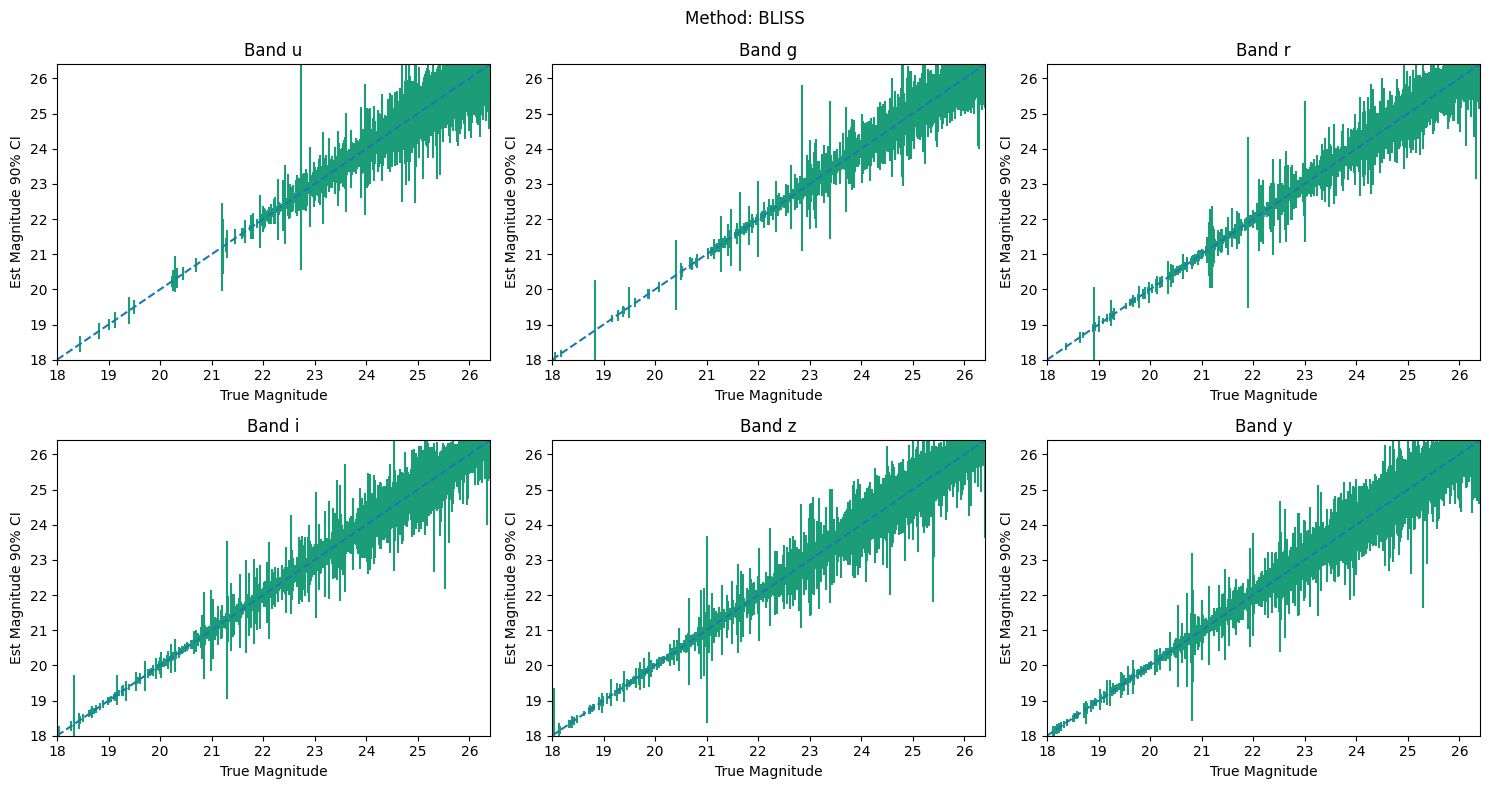

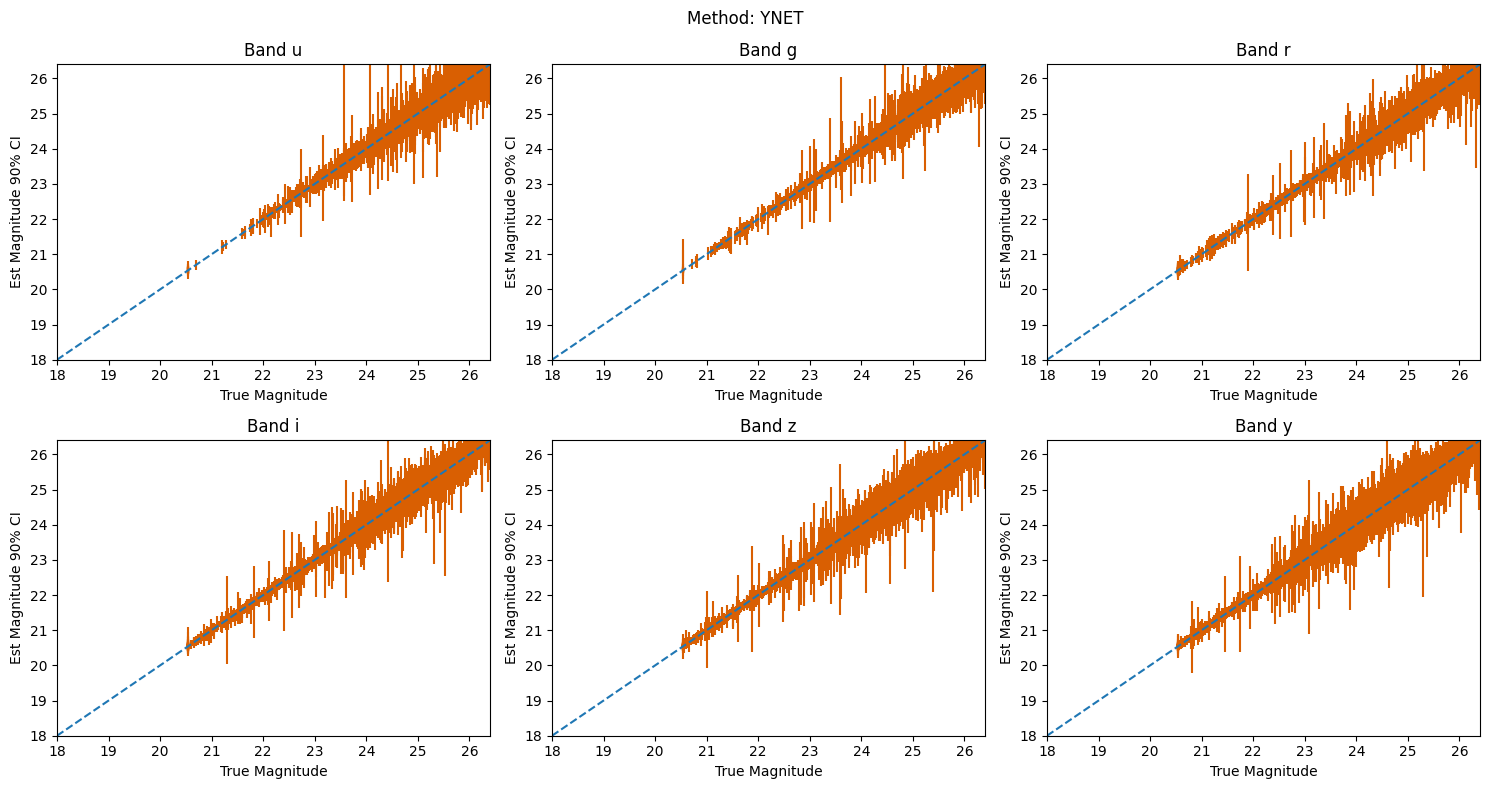

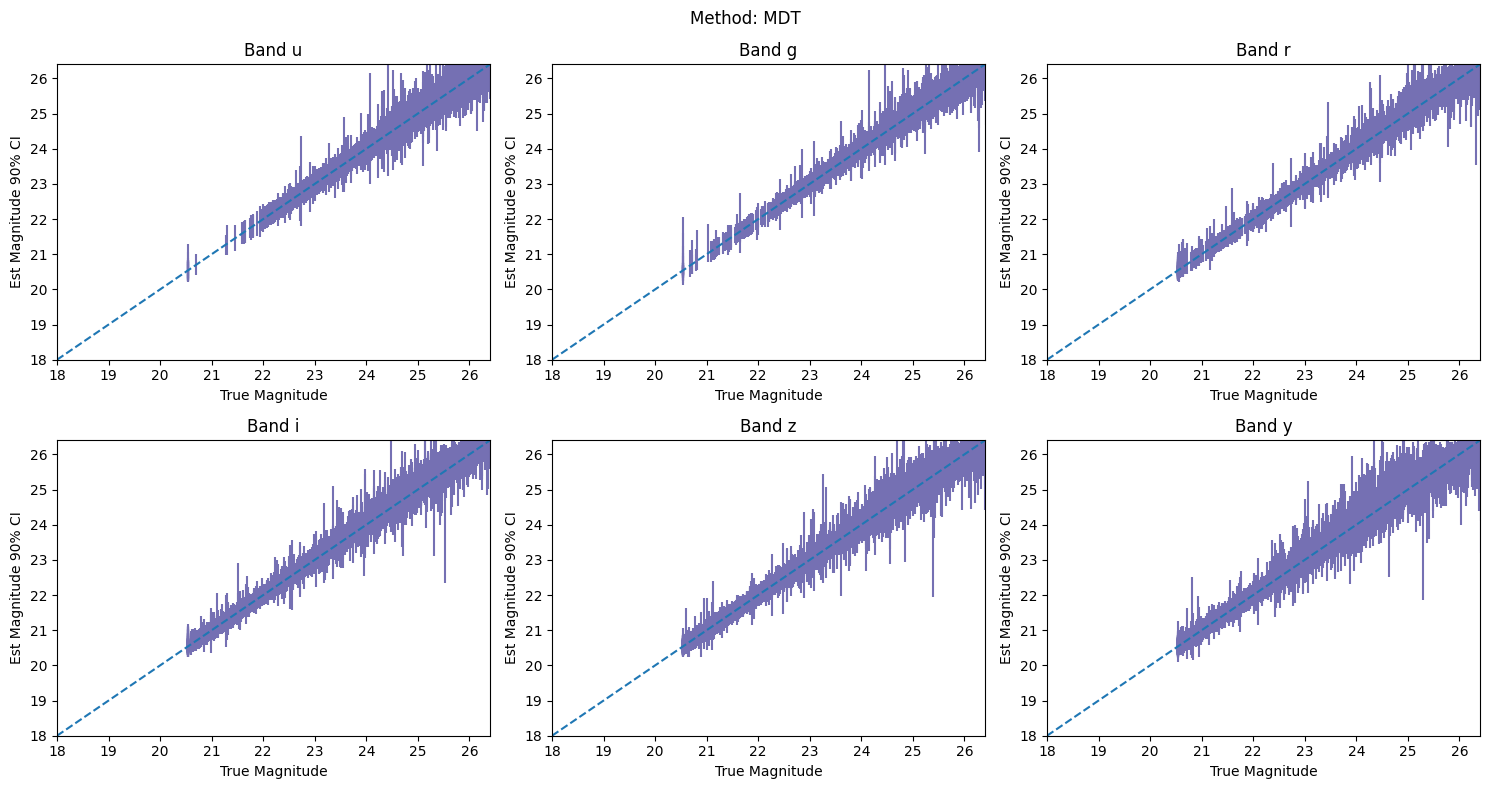

In [17]:
draw_fluxes_ci_match_plot(ci_cover=0.90)